### This image data contains around 25k images of size 150x150 distributed under 6 categories.

#### All images are divided into 6 classes:
{'buildings' -> 0,<br>
 'forest' -> 1,<br>
 'glacier' -> 2,<br>
 'mountain' -> 3,<br>
 'sea' -> 4,<br>
 'street' -> 5 }<br>

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.<br>

### You are asked to train a model with following steps:
1. Download data and get familiarized with it.<br>
2. Normalize and preprocess data.<br>
3. Visualize a batch of training data.<br>
4. Specify Loss Function and Optimizer.<br>
5. Train the Model.<br>
6. Load the model with the lowest validation loss.<br>
7. Test the trained network.<br>
8. Create a subfolder containing all the unlabeled images in seg_pred to make PyTorch's ImageFolder work.

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

data_dir = r'C:\Users\Administrator\Desktop\DSA_Bootcamp26\Week 11\Python\HW_CS\intel_image_classification (W11D1_HW)'

In [2]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageFolder(os.path.join(data_dir, 'seg_train'), transform=transform)
test_dataset = ImageFolder(os.path.join(data_dir, 'seg_test'), transform=transform)
predict_dataset = ImageFolder(os.path.join(data_dir, 'seg_pred'), transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
predict_loader = DataLoader(predict_dataset, batch_size=batch_size)

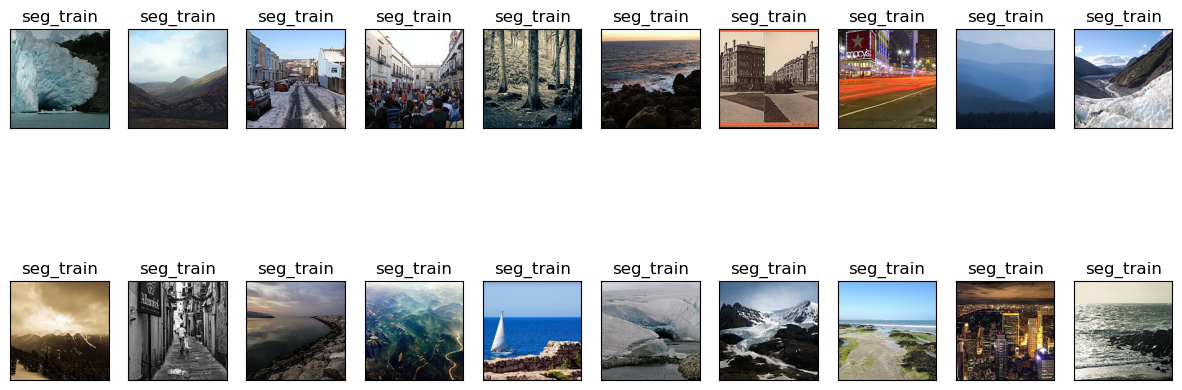

In [4]:
def visualize_data(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    mean = np.array([0.485, 0.456, 0.406])  # reverse normalization for visualization
    std = np.array([0.229, 0.224, 0.225])
    
    fig = plt.figure(figsize=(15, 6))
    for idx in range(20):
        image = images[idx].numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
        plt.imshow(image)
        ax.set_title(train_dataset.classes[labels[idx]])
    plt.show()

visualize_data(train_loader)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 75 * 75, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 75 * 75)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    lowest_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            save_path = 'best_model.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }, save_path)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(test_loader)}")

train_model(model, train_loader, test_loader, criterion, optimizer)

Epoch 1/10, Loss: 0.008056625452908603, Validation Loss: 0.0
Epoch 2/10, Loss: 0.0, Validation Loss: 0.0
Epoch 3/10, Loss: 0.0, Validation Loss: 0.0
Epoch 4/10, Loss: 0.0, Validation Loss: 0.0
Epoch 5/10, Loss: 0.0, Validation Loss: 0.0
Epoch 6/10, Loss: 0.0, Validation Loss: 0.0
Epoch 7/10, Loss: 0.0, Validation Loss: 0.0
Epoch 8/10, Loss: 0.0, Validation Loss: 0.0
Epoch 9/10, Loss: 0.0, Validation Loss: 0.0
Epoch 10/10, Loss: 0.0, Validation Loss: 0.0


In [7]:
def load_best_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['loss']
    return model, optimizer, epoch, val_loss

model, optimizer, best_epoch, best_val_loss = load_best_model(model, optimizer, '(W11D1_HW) best_model.pth')

In [8]:
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Loss: {running_loss / len(test_loader)}, Accuracy: {accuracy}%")

test_model(model, test_loader, criterion)

Test Loss: 0.0, Accuracy: 100.0%
